In [1]:
# imports
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, MetricFrame # for predictive_parity_odds

from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

'''
============================================================
 Functions for Data Pre-Processing
============================================================
'''

DATA_DIR = "" # todo: modify this path to match your folder path

def load_taiwan_dataset(test_size=0.3, val_size=0.2, random_state=42, sensitive="sex"):
    '''
    Load the Taiwan dataset (UCI Credit Card).
    sensitive: str, "sex" or "age"
    '''
    path = os.path.join(DATA_DIR, "UCI_Credit_Card.csv")
    df = pd.read_csv(path)
    df = df.drop(columns=["ID"])

    # Target
    y = df["default.payment.next.month"].values

    # Sensitive attributes
    df["SEX_BIN"] = df["SEX"].map({1: 1, 2: 0})
    df["AGE_NUM"] = df["AGE"]
    df["AGE_GROUP"] = pd.cut(
        df["AGE"], bins=[0, 25, 35, 45, 60, 120], labels=[0, 1, 2, 3, 4]
    ).astype(int)

    if sensitive.lower() == "sex":
        A = df["SEX_BIN"].values
    else:
        A = df["AGE_GROUP"].values

    df_features = df.drop(columns=["default.payment.next.month"])
    X = pd.get_dummies(df_features, drop_first=True)

    X_temp, X_test, y_temp, y_test, A_temp, A_test = train_test_split(
        X, y, A,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )

    val_rel = val_size / (1.0 - test_size)
    X_train, X_val, y_train, y_val, A_train, A_val = train_test_split(
        X_temp, y_temp, A_temp,
        test_size=val_rel,
        stratify=y_temp,
        random_state=random_state,
    )

    scaler = StandardScaler()
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_val[num_cols] = scaler.transform(X_val[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    return (
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        A_train, A_val, A_test,
        scaler,
    )

def load_german_dataset(test_size=0.3, val_size=0.2, random_state=42, sensitive="sex"):
    '''
    Load the German dataset (German Credit).
    sensitive: str, "sex" or "age"
    '''
    path = os.path.join(DATA_DIR, "Processed_German_Credit.csv")
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower()

    # Target
    y = df["credit"].values

    df["sex_bin"] = df["sex"].map({"male": 1, "female": 0})

    df["age_num"] = df["age"]
    df["age_group"] = pd.cut(
        df["age"], bins=[0, 25, 35, 45, 60, 120], labels=[0, 1, 2, 3, 4]
    ).astype(int)

    if sensitive.lower() == "sex":
        A = df["sex_bin"].values
    else:
        A = df["age_group"].values

    df_features = df.drop(columns=["credit"])
    X = pd.get_dummies(df_features, drop_first=True)

    X_temp, X_test, y_temp, y_test, A_temp, A_test = train_test_split(
        X, y, A,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )

    val_rel = val_size / (1.0 - test_size)
    X_train, X_val, y_train, y_val, A_train, A_val = train_test_split(
        X_temp, y_temp, A_temp,
        test_size=val_rel,
        stratify=y_temp,
        random_state=random_state,
    )

    scaler = StandardScaler()
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_val[num_cols] = scaler.transform(X_val[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    return (
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        A_train, A_val, A_test,
        scaler,
    )

def load_dataset(name, sensitive="sex", **kwargs):
    '''
    Call either load_taiwan_dataset() or load_german_dataset() functions to load the dataset.
    '''
    if name.lower() == 'taiwan':
        return load_taiwan_dataset(sensitive=sensitive, **kwargs)
    elif name.lower() == 'german':
        return load_german_dataset(sensitive=sensitive, **kwargs)
    else:
        raise ValueError(f"Unknown dataset: {name}")

print("\n--- TAIWAN DATASET CHECK ---")
X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t, A_train_t, A_val_t, A_test_t, _ = load_taiwan_dataset()
print(f"Taiwan X_train shape: {X_train_t.shape}")
print(f"Taiwan X_test shape: {X_test_t.shape}")
print(f"Taiwan X_val shape: {X_val_t.shape}")
print(f"Taiwan A_train unique values: {np.unique(A_train_t)}")

print("\n--- GERMAN DATASET CHECK ---")
X_train_g, X_val_g, X_test_g, y_train_g, y_val_g, y_test_g, A_train_g, A_val_g, A_test_g, _ = load_german_dataset(sensitive="age")
print(f"German X_train shape: {X_train_g.shape}")
print(f"German X_test shape: {X_test_g.shape}")
print(f"Taiwan X_val shape: {X_val_g.shape}")
print(f"German A_train unique values: {np.unique(A_train_g)}")


--- TAIWAN DATASET CHECK ---
Taiwan X_train shape: (14999, 26)
Taiwan X_test shape: (9000, 26)
Taiwan X_val shape: (6001, 26)
Taiwan A_train unique values: [0 1]

--- GERMAN DATASET CHECK ---
German X_train shape: (499, 24)
German X_test shape: (300, 24)
Taiwan X_val shape: (201, 24)
German A_train unique values: [0 1 2 3 4]


In [2]:
''' 
============================================================
 Functions for Computing Evaluation Metrics
============================================================
'''
def compute_metrics(y_true, y_pred, A):
    '''
    computes evaluation metrics (acc, prec, rec, f1, mcc), confusion matrix, and 
    fairness metrics (absolute differences of dp, eo, pp).
    '''

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)

    metric_frame = MetricFrame(
        metrics={"precision": precision_score},
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=A
    )
    group_precision = metric_frame.by_group['precision']
    
    dp_diff = demographic_parity_difference(y_true=y_true, y_pred=y_pred, sensitive_features=A)
    eo_diff = equalized_odds_difference(y_true=y_true, y_pred=y_pred, sensitive_features=A)
    pp_diff = abs(group_precision.max() - group_precision.min())
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mcc": mcc,
        "dp_diff": dp_diff,
        "eo_diff": eo_diff,
        "pp_diff": pp_diff,
        "confusion_matrix": confusion_matrix(y_true, y_pred),
    }

def predictive_parity_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    ppv = {}

    for g in groups:
        mask = sensitive_features == g
        preds_pos = (y_pred[mask] == 1)
        
        if preds_pos.sum() == 0:
            ppv[g] = 0 
        else:
            ppv[g] = (y_true[mask][preds_pos] == 1).mean()

    gaps = []
    for g1 in groups:
        for g2 in groups:
            gaps.append(abs(ppv[g1] - ppv[g2]))

    return max(gaps)

def compute_group_error_rates(y_true, y_pred, A):
    '''
    Solves group-specific False Positive Rate (FPR) and 
    False Negative Rate (FNR) for each group in A.
    Helper function for graphing error rates.
    '''
    # Assume 0 is negative class, 1 is positive class
    groups = np.unique(A)
    rates = {}

    for group in groups:
        mask = A == group
        y_true_g = y_true[mask]
        y_pred_g = y_pred[mask]
        
        TN = np.sum((y_true_g == 0) & (y_pred_g == 0))
        FP = np.sum((y_true_g == 0) & (y_pred_g == 1))
        FN = np.sum((y_true_g == 1) & (y_pred_g == 0))
        TP = np.sum((y_true_g == 1) & (y_pred_g == 1))

        # False Positive Rate (FPR): FP / (TN + FP)
        N_g = TN + FP # True Negatives + False Positives = total actual negatives
        FPR_g = FP / N_g if N_g > 0 else 0.0

        # False Negative Rate (FNR): FN / (FN + TP)
        P_g = FN + TP # False Negatives + True Positives = total actual positives
        FNR_g = FN / P_g if P_g > 0 else 0.0

        rates[group] = {"FPR": FPR_g, "FNR": FNR_g}
        
    return rates

In [3]:
''' 
============================================================
 Functions for Plotting Figures
============================================================
'''

def plot_pareto_tradeoff(val_results, title_suffix=""):
    '''
    Plot the pareto-style trade-off for accuracy vs all fairness metrics
    '''
    lambdas = [res["lambda"] for res in val_results]
    accs = [res["accuracy"] for res in val_results]
    dps = [res["dp"] for res in val_results]
    eos = [res["eo"] for res in val_results]
    pps = [res["pp"] for res in val_results]

    plt.figure(figsize=(8, 6))

    plt.plot(dps, accs, marker="o", label="DP (ΔP)")
    plt.plot(eos, accs, marker="s", label="EO (ΔTPR + ΔFPR)")
    plt.plot(pps, accs, marker="^", label="PP (ΔPPV)")

    for dp, eo, pp, acc, lam in zip(dps, eos, pps, accs, lambdas):
        plt.annotate(f"{lam}", (dp, acc), textcoords="offset points", xytext=(5, 5), fontsize=8)
        plt.annotate(f"{lam}", (eo, acc), textcoords="offset points", xytext=(5, 5), fontsize=8)
        plt.annotate(f"{lam}", (pp, acc), textcoords="offset points", xytext=(5, 5), fontsize=8)

    plt.xlabel("Fairness Metric Value (lower = fairer)")
    plt.ylabel("Validation Accuracy")
    plt.title(f"Accuracy vs Fairness Tradeoff {title_suffix}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_error_rate_disparity(group_rates, sensitive_attribute_name, title):
    '''
    Plots FPR and FNR for each group in a sensitive attribute.
    '''
    groups = list(group_rates.keys())
    fpr_values = [group_rates[g]["FPR"] for g in groups]
    fnr_values = [group_rates[g]["FNR"] for g in groups]
    
    x = np.arange(len(groups)) 
    width = 0.35 

    fig, ax = plt.subplots(figsize=(8, 6))
    
    rects1 = ax.bar(x - width/2, fpr_values, width, label='FPR (False Positive Rate)', color='skyblue', alpha=0.8)
    rects2 = ax.bar(x + width/2, fnr_values, width, label='FNR (False Negative Rate)', color='salmon', alpha=0.8)

    ax.set_ylabel('Error Rate')
    ax.set_xlabel(f'Sensitive Attribute: {sensitive_attribute_name}')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1)
    autolabel(rects2)
    plt.tight_layout()
    plt.show()
    
def plot_lambda_sensitivity(results, fairness_key="dp_diff", title="Lambda Sensitivity"):
    lambdas = [r["lambda"] for r in results]
    acc = [r["accuracy"] for r in results]
    fairness = [r[fairness_key] for r in results]

    fig, ax1 = plt.subplots(figsize=(7,5))
    
    ax1.plot(lambdas, acc, marker="o", label="Accuracy")
    ax1.set_xlabel("Lambda")
    ax1.set_ylabel("Accuracy")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(lambdas, fairness, marker="s", color="red", label=fairness_key.upper())
    ax2.set_ylabel(f"{fairness_key.upper()} Gap", color="red")

    plt.title(title)
    plt.show()

def plot_training_dynamics(round_metrics, fairness_key="dp_diff", title="Boosting Dynamics"):
    rounds = [m["round"] for m in round_metrics]
    accs = [m["accuracy"] for m in round_metrics]
    fairness_vals = [m[fairness_key] for m in round_metrics]

    plt.figure(figsize=(8, 5))

    plt.plot(rounds, accs, marker="o", label="Accuracy")
    plt.plot(rounds, fairness_vals, marker="s", label=fairness_key)

    plt.xlabel("Boosting Round")
    plt.ylabel("Metric Value")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_threshold_satisfaction_heatmap(val_results, metrics=("accuracy", "dp", "eo", "pp"), title="Threshold Satisfaction Heatmap"):
    model_names = []
    for r in val_results:
        if r["lambda"] == 0:
            model_names.append("baseline")
        else:
            model_names.append(f"λ={r['lambda']}")

    data = []
    for r in val_results:
        row = []
        for m in metrics:
            row.append(r[m])   
        data.append(row)

    df = pd.DataFrame(data, columns=metrics, index=model_names)

    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, fmt=".3f", cmap="coolwarm", linewidths=.5)
    plt.title(title)
    plt.xlabel("Metrics")
    plt.ylabel("Models")
    plt.tight_layout()
    plt.show()

In [4]:
''' 
============================================================
 AdaBoost implementation
============================================================
'''
class AdaBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, 
                 base_estimator=None, 
                 n_estimators=50, 
                 learning_rate=1.0,
                 fairness_lambda=0.0,
                 fairness_tolerance=0.5,
                 random_state=None):

        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.fairness_lambda = fairness_lambda
        self.fairness_tolerance = fairness_tolerance

        self.estimators_ = []
        self.estimator_weights_ = []
        self.classes_ = None

        self.round_metrics = []     # store metrics per round
        self.training_time_ = None
        self.last_predict_time_ = None
        
        # --- NEW Attributes for Plotting ---
        self.training_error = [] # Store (1 - accuracy) for each round/epoch
        self.validation_error = [] # Store (round, 1 - accuracy, F1) for validation

    def check_binary(self, y):
        y = np.asarray(y)
        classes = np.unique(y)
        if len(classes) != 2:
            raise ValueError("Binary classification only.")

        self.classes_ = classes
        return (y == classes[1]).astype(int)

    def fit(self, X, y, A=None, X_val=None, y_val=None):
        '''
        fit with fairness modification using demographic parity gap.
        A is the sensitive attribute (0/1).
        
        NOTE: X_val and y_val are added to allow tracking validation error
        '''
        if self.base_estimator is None:
            raise ValueError("base_estimator must be provided.")

        if A is None:
            raise ValueError("Sensitive attribute A must be provided for fairness-aware training.")

        X = np.asarray(X)
        y = np.asarray(y)
        A = np.asarray(A)

        y01 = self.check_binary(y)
        n_samples = X.shape[0]

        sample_weight = np.ones(n_samples) / n_samples
        rng = np.random.RandomState(self.random_state) # random states

        start_time = time.perf_counter()
        self.estimators_ = []
        self.estimator_weights_ = []
        self.training_error = [] # Reset training error
        self.validation_error = [] # Reset validation error

        for t in range(self.n_estimators):
            est_idx = t % len(self.base_estimator)
            est = clone(self.base_estimator[est_idx])
            # print(f"Round {t}: Using estimator {type(est).__name__}")
            
            idx = rng.choice(
                np.arange(n_samples),
                size=n_samples,
                replace=True,
                p=sample_weight
            )
            est.fit(X[idx], y01[idx])

            y_pred = est.predict(X).astype(int)
            incorrect = (y_pred != y01).astype(float)

            err = np.dot(sample_weight, incorrect) / sample_weight.sum()
            err = np.clip(err, 1e-10, 1 - 1e-10)
            acc = accuracy_score(y, y_pred)
            
            # --- Track Training Error ---
            self.training_error.append(1.0 - acc) # 1 - Accuracy = Error Rate

            lambda_dp = 0.4
            lambda_eo = 0.7
            lambda_pp = 1.0
            
            dp_gap = demographic_parity_difference(y_true=y01, y_pred=y_pred, sensitive_features=A)
            eo_gap = equalized_odds_difference(y_true=y01, y_pred=y_pred, sensitive_features=A)
            pp_gap = predictive_parity_difference(y01, y_pred, A)

            dp = np.clip(dp_gap, 0, 1)
            eo = np.clip(eo_gap, 0, 1)
            pp = np.clip(pp_gap, 0, 1)
            
            if self.fairness_lambda >= self.fairness_tolerance: # with fairness ON
                fairness_penalty = (lambda_dp * dp) + (lambda_eo * eo) + (lambda_pp * pp)
                lambda_t = np.exp(-self.fairness_lambda * fairness_penalty)
            else: # fairness OFF (baseline AdaBoost)
                fairness_penalty = 0.0
                lambda_t = 1.0

            alpha = 0.5 * np.log((1 - err) / err) * self.learning_rate
            if alpha <= 0:
                break

            # ... [Rest of weight update logic is unchanged] ...
            sample_weight *= np.exp(-alpha * (2 * y01 - 1) * (2 * y_pred - 1))
            sample_weight *= np.exp(-self.fairness_lambda * fairness_penalty)
            sample_weight /= sample_weight.sum()

            self.estimators_.append(est)
            self.estimator_weights_.append(alpha * lambda_t)
            
            # --- Track Validation Error (if provided) ---
            if X_val is not None and y_val is not None:
                # Need to calculate ensemble prediction *after* adding the new estimator
                y_val_pred_ens = self.predict(X_val) 
                val_acc = accuracy_score(y_val, y_val_pred_ens)
                val_f1 = f1_score(y_val, y_val_pred_ens, zero_division=0)
                # Store: (round, error, f1_score)
                self.validation_error.append((t + 1, 1.0 - val_acc, val_f1))

            self.round_metrics.append({
                "round": t + 1,
                "accuracy": acc,
                "dp_diff": dp,
                "eo_diff": eo,
                "pp_diff": pp
            })

        self.estimator_weights_ = np.array(self.estimator_weights_)
        end_time = time.perf_counter()
        self.training_time_ = end_time - start_time
        return self

    def scores(self, X):
        X = np.asarray(X)
        scores = np.zeros(X.shape[0])

        for alpha, est in zip(self.estimator_weights_, self.estimators_):
            pred = est.predict(X).astype(int)
            pred_pm1 = 2 * pred - 1
            scores += alpha * pred_pm1

        return scores

    def predict(self, X):
        start_time = time.perf_counter()
        scores = self.scores(X)
        y01 = (scores >= 0).astype(int)
        end_time = time.perf_counter()
        self.last_predict_time_ = end_time - start_time
        return np.where(y01 == 1, self.classes_[1], self.classes_[0])

    def predict_proba(self, X):
        scores = self.scores(X)
        p_pos = 1 / (1 + np.exp(-2 * scores))
        return np.vstack([1 - p_pos, p_pos]).T

    # --- NEW Plotting Method (Renamed for clarity, using Error Rate) ---
    def plot_error_curve(self, filename="learning_curves_error_per_epoch.png"):
        ''' Plots the Classification Error Rate (1 - Accuracy) over boosting rounds. '''
        plt.figure(figsize=(8,5))
        epochs_training = np.arange(1, len(self.training_error) + 1)
        plt.plot(epochs_training, self.training_error, label="Training Error", color="tab:blue", marker="x", linewidth=2)

        if self.validation_error:
            epochs_validation = [e for (e, _, _) in self.validation_error]
            error_value_validation = [err for (_, err, _) in self.validation_error]
            plt.plot(epochs_validation, error_value_validation, label="Validation Error", color="tab:orange", marker='o', linewidth=2)

        plt.title("Classification Error Rate per Boosting Round")
        plt.xlabel("Boosting Round")
        plt.ylabel("Classification Error Rate (1 - Accuracy)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()

        plt.savefig(filename, dpi=300)
        print(f"Error Learning curve plot saved to {filename}")

        plt.show()
def run_experiment(
    dataset_name,
    sensitive="sex",
    lambdas=(0.0, 0.1, 0.3, 0.5, 1.0),
    n_estimators=50,
    fairness_tolerance=0.05, # for fairness modifications
):
    '''
    runs the experiment for a given dataset and sensitive attribute.
    '''
    (
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        A_train, A_val, A_test, # this is for the fairness modification
        scaler,
    ) = load_dataset(dataset_name, sensitive=sensitive)

    print(f"Dataset: {dataset_name}, sensitive: {sensitive}")
    print("Train shape:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

    base = [
        Perceptron(max_iter=1000, eta0=0.01, random_state=0, tol=1e-3, fit_intercept=True),
        SVC(probability=True, kernel='rbf', C=1.0),
        MLPClassifier(
            hidden_layer_sizes=(128, 32),
            max_iter=500,
            early_stopping=True,
            n_iter_no_change=20,
            validation_fraction=0.1,
            random_state=42,
            learning_rate_init=0.001,
        )
    ]

    val_results = []

    for lam in lambdas:
        model = AdaBoostClassifier(
            base_estimator=base,
            n_estimators=n_estimators,
            learning_rate=1.0,
            fairness_lambda=lam, # for fairness modifications
            fairness_tolerance=fairness_tolerance # for fairness modifications
        )
        # fairness-aware fit uses A_train
        # model.fit(X_train, y_train, A_train)
        # fairness-aware fit uses A_train and also tracks validation loss
        model.fit(X_train, y_train, A_train, X_val=X_val, y_val=y_val)
        y_val_pred = model.predict(X_val)

        metrics = compute_metrics(y_val, y_val_pred, A_val)
        metrics["lambda"] = lam
        
        val_results.append({
            "metrics": metrics,
            "lambda": lam,
            "accuracy": metrics['accuracy'],
            "dp": metrics['dp_diff'],
            "eo": metrics['eo_diff'],
            "pp": metrics['pp_diff'],
            "training_time": model.training_time_,       
            "validation_time": model.last_predict_time_,  
            "round_metrics": model.round_metrics
        })

        print(
            f"lambda={lam:.2f} | "
            f"Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}, "
            f"MCC={metrics['mcc']:.3f}, DP={metrics['dp_diff']:.3f}, "
    	    f"EO={metrics['eo_diff']:.3f}, PP={metrics['pp_diff']:.3f}, "
            f"Train Time={model.training_time_:.2f}s, "
            f"Val Time={model.last_predict_time_:.4f}s" 
        )

    best_idx = np.argmax([metrics["f1"] for m in val_results])
    best_lam = val_results[best_idx]["lambda"]
    print("\nBest lambda on validation (by F1):", best_lam)

    X_tr_full = pd.concat([X_train, X_val], axis=0)
    y_tr_full = np.concatenate([y_train, y_val])
    A_tr_full = np.concatenate([A_train, A_val])

    baseline_lam = 0.0
    
    baseline_model = AdaBoostClassifier(
        base_estimator=base,
        n_estimators=n_estimators,
        learning_rate=1.0,
        fairness_lambda=baseline_lam,
        fairness_tolerance=fairness_tolerance,
    )
    baseline_model.fit(X_tr_full, y_tr_full, A_tr_full)
    y_test_pred_baseline = baseline_model.predict(X_test)
    baseline_rates = compute_group_error_rates(y_test, y_test_pred_baseline, A_test)
    
    best_model = AdaBoostClassifier(
        base_estimator=base,
        n_estimators=n_estimators,
        learning_rate=1.0,
        fairness_lambda=best_lam,
        fairness_tolerance=fairness_tolerance,
    )
    best_model.fit(X_tr_full, y_tr_full, A_tr_full)
    y_test_pred_best = best_model.predict(X_test)
    best_fair_rates = compute_group_error_rates(y_test, y_test_pred_best, A_test)

    test_metrics = compute_metrics(y_test, y_test_pred_best, A_test)
    test_metrics["training_time"] = best_model.training_time_
    test_metrics["testing_time"] = best_model.last_predict_time_
    
    print("\n=== Test metrics with best lambda ===")
    for k, v in test_metrics.items():
        if k == "confusion_matrix":
            print(k, "=\n", v)
        else:
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    return val_results, test_metrics, baseline_rates, best_fair_rates

Dataset: german, sensitive: sex
Train shape: (499, 24) Val: (201, 24) Test: (300, 24)
lambda=0.00 | Acc=0.726, F1=0.466, MCC=0.296, DP=0.139, EO=0.215, PP=0.265, Train Time=2.21s, Val Time=0.0172s
lambda=0.10 | Acc=0.697, F1=0.450, MCC=0.244, DP=0.125, EO=0.253, PP=0.337, Train Time=4.66s, Val Time=0.0554s
lambda=0.30 | Acc=0.701, F1=0.444, MCC=0.247, DP=0.102, EO=0.283, PP=0.429, Train Time=2.72s, Val Time=0.0395s
lambda=0.50 | Acc=0.716, F1=0.467, MCC=0.282, DP=0.223, EO=0.253, PP=0.145, Train Time=2.49s, Val Time=0.0430s
lambda=0.80 | Acc=0.692, F1=0.456, MCC=0.242, DP=0.126, EO=0.222, PP=0.297, Train Time=5.12s, Val Time=0.0563s
lambda=1.00 | Acc=0.721, F1=0.391, MCC=0.251, DP=0.174, EO=0.263, PP=0.238, Train Time=1.53s, Val Time=0.0150s

Best lambda on validation (by F1): 0.0

=== Test metrics with best lambda ===
accuracy: 0.6967
precision: 0.4940
recall: 0.4556
f1: 0.4740
mcc: 0.2618
dp_diff: 0.1286
eo_diff: 0.1429
pp_diff: 0.0655
confusion_matrix =
 [[168  42]
 [ 49  41]]
train

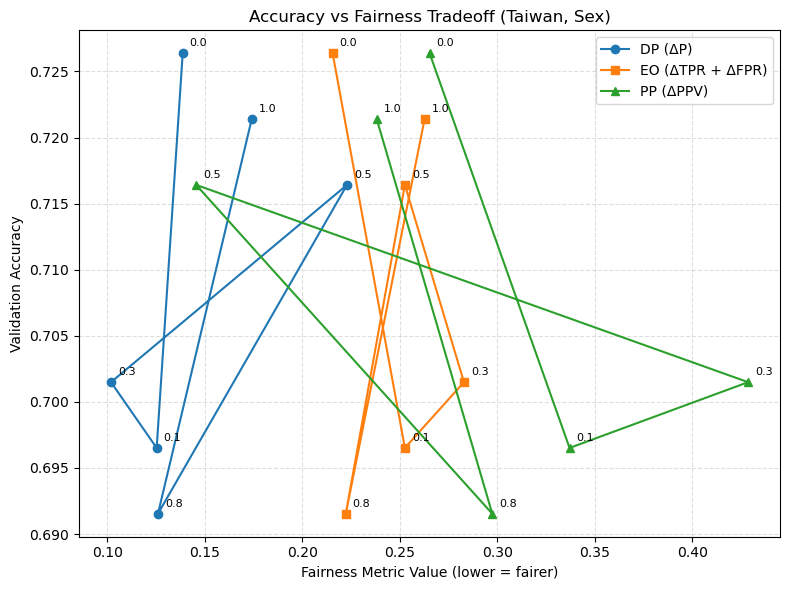

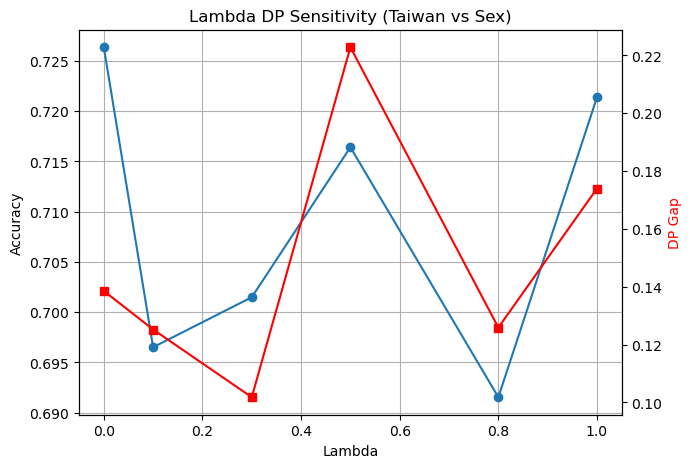

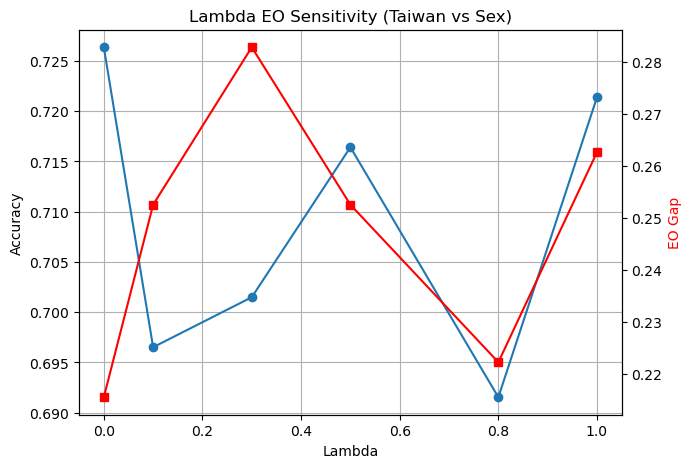

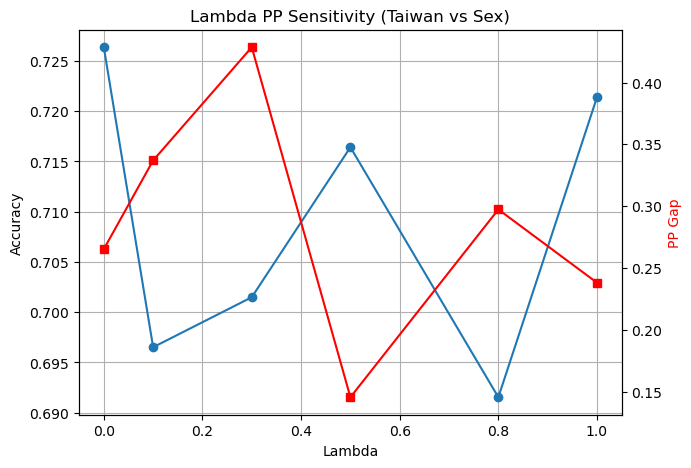

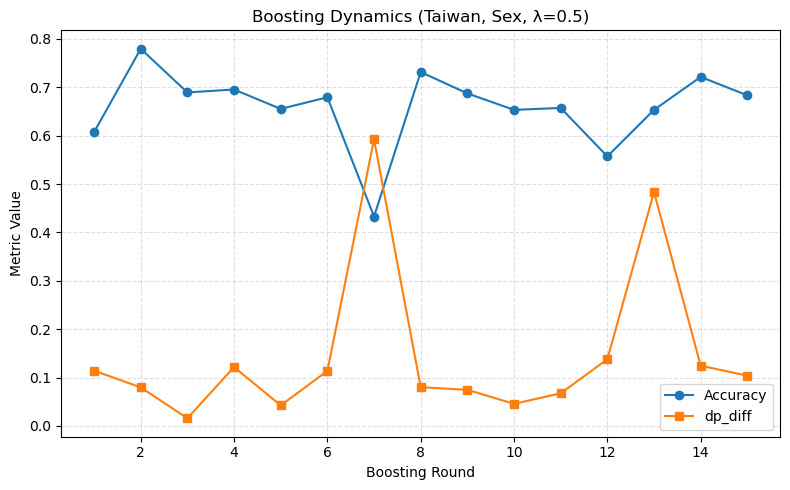

Error Learning curve plot saved to Taiwan_Sex_lambda_0.5_error_curve.png


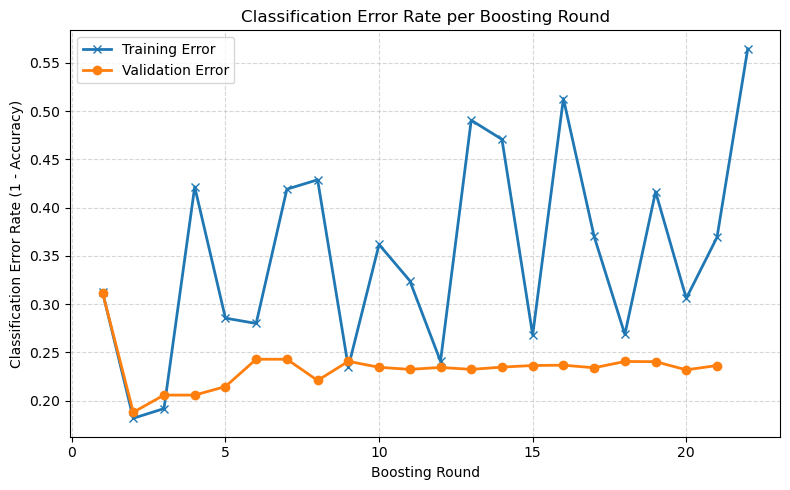

In [6]:
''' 
==================================================================
 Run AdaBoost experiments (Round-Robin Heterogeneous)
==================================================================
'''

# --- Define the list of base estimators globally ---
base = [
    Perceptron(max_iter=1000, eta0=0.01, random_state=0, tol=1e-3, fit_intercept=True),
    SVC(probability=True, kernel='rbf', C=1.0),
    MLPClassifier(
        hidden_layer_sizes=(128, 32),
        max_iter=500,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.1,
        random_state=42,
        learning_rate_init=0.001,
    )
]

# Ensure you also update the run_experiment function to remove its local 'base' definition, 
# or change it to use the global 'base' list, but since your implementation 
# passes 'base' to AdaBoost, defining it once globally is the cleanest solution.
# If you don't change run_experiment, it will still work as it will use its local copy, 
# but defining it globally allows the final execution block to use it.


# Taiwan dataset fairness on sex
val_res_taiwan_sex, test_taiwan_sex, baseline_taiwan_sex, best_taiwan_sex = run_experiment(
    dataset_name="german",
    sensitive="sex",
    lambdas=(0.0, 0.1, 0.3, 0.5, 0.8, 1.0),
    n_estimators=40,
    fairness_tolerance=0.5, # for fairness modifications
)

plot_pareto_tradeoff(val_res_taiwan_sex, title_suffix="(Taiwan, Sex)")
plot_lambda_sensitivity(val_res_taiwan_sex, fairness_key="dp", title="Lambda DP Sensitivity (Taiwan vs Sex)") 
plot_lambda_sensitivity(val_res_taiwan_sex, fairness_key="eo", title="Lambda EO Sensitivity (Taiwan vs Sex)") 
plot_lambda_sensitivity(val_res_taiwan_sex, fairness_key="pp", title="Lambda PP Sensitivity (Taiwan vs Sex)")

# Find the best model result (by F1) for plotting its dynamics
best_f1_idx = np.argmax([r["metrics"]["f1"] for r in val_res_taiwan_sex])
best_model_val_res = val_res_taiwan_sex[best_f1_idx]
plot_training_dynamics(
    best_model_val_res["round_metrics"], 
    fairness_key="dp_diff", 
    title=f"Boosting Dynamics (Taiwan, Sex, λ={best_model_val_res['lambda']:.1f})"
)

# Instantiate the best model again to call the plot_error_curve method
best_lam = best_model_val_res["lambda"]
plot_model = AdaBoostClassifier(
    # 'base' is now defined in the global scope, resolving the NameError
    base_estimator=base, 
    n_estimators=40, # same as n_estimators in run_experiment
    learning_rate=1.0,
    fairness_lambda=best_lam,
    fairness_tolerance=0.5,
)
# Retrain to populate the .training_error and .validation_error lists
plot_model.fit(X_train_t, y_train_t, A_train_t, X_val_t, y_val_t) # Using the initial train/val splits from the check block
plot_model.plot_error_curve(filename=f"Taiwan_Sex_lambda_{best_lam:.1f}_error_curve.png")

In [ ]:
# Taiwan dataset fairness on age
val_res_taiwan_age, test_taiwan_age, baseline_taiwan_age, best_taiwan_age = run_experiment(
    dataset_name="taiwan",
    sensitive="age",
    lambdas=(0.0, 0.1, 0.3, 0.5, 0.8, 1.0),
    n_estimators=40,
    fairness_tolerance=0.5,
)

plot_pareto_tradeoff(val_res_taiwan_age, title_suffix="(Taiwan, Age)")
plot_lambda_sensitivity(val_res_taiwan_age, fairness_key="dp", title="Lambda DP Sensitivity (Taiwan vs Age)")
plot_lambda_sensitivity(val_res_taiwan_age, fairness_key="eo", title="Lambda EO Sensitivity (Taiwan vs Age)")
plot_lambda_sensitivity(val_res_taiwan_age, fairness_key="pp", title="Lambda PP Sensitivity (Taiwan vs Age)")

Dataset: german, sensitive: sex
Train shape: (499, 24) Val: (201, 24) Test: (300, 24)
lambda=0.00 | Acc=0.706, F1=0.459, MCC=0.263, DP=0.140, EO=0.253, PP=0.311, Train Time=1.81s, Val Time=0.0175s
lambda=0.10 | Acc=0.731, F1=0.509, MCC=0.329, DP=0.087, EO=0.094, PP=0.233, Train Time=2.03s, Val Time=0.0393s
lambda=0.30 | Acc=0.672, F1=0.353, MCC=0.146, DP=0.078, EO=0.061, PP=0.169, Train Time=1.59s, Val Time=0.0328s
lambda=0.50 | Acc=0.682, F1=0.360, MCC=0.165, DP=0.070, EO=0.195, PP=0.396, Train Time=1.54s, Val Time=0.0251s
lambda=0.80 | Acc=0.706, F1=0.459, MCC=0.263, DP=0.072, EO=0.118, PP=0.284, Train Time=2.76s, Val Time=0.0510s
lambda=1.00 | Acc=0.716, F1=0.477, MCC=0.288, DP=0.072, EO=0.155, PP=0.337, Train Time=3.48s, Val Time=0.0441s

Best lambda on validation (by F1): 0.0

=== Test metrics with best lambda ===
accuracy: 0.6767
precision: 0.4615
recall: 0.4667
f1: 0.4641
mcc: 0.2326
dp_diff: 0.1540
eo_diff: 0.1799
pp_diff: 0.0490
confusion_matrix =
 [[161  49]
 [ 48  42]]
train

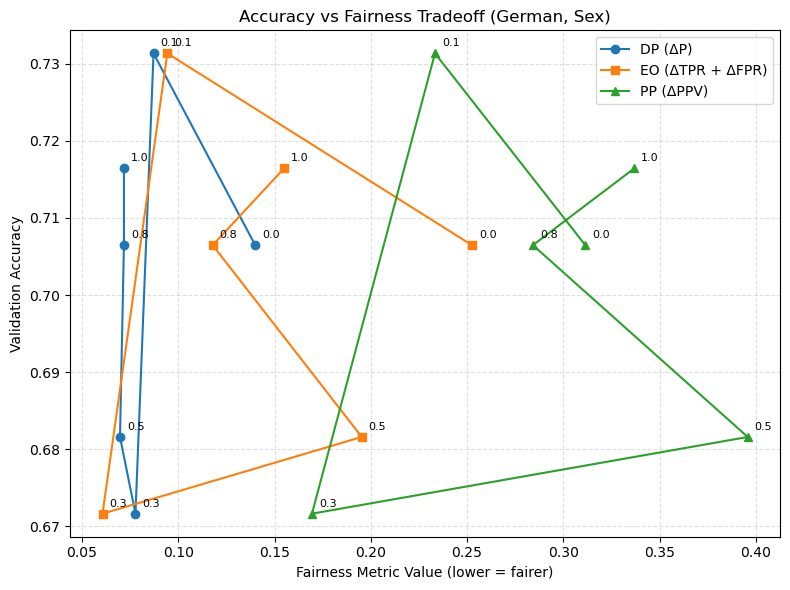

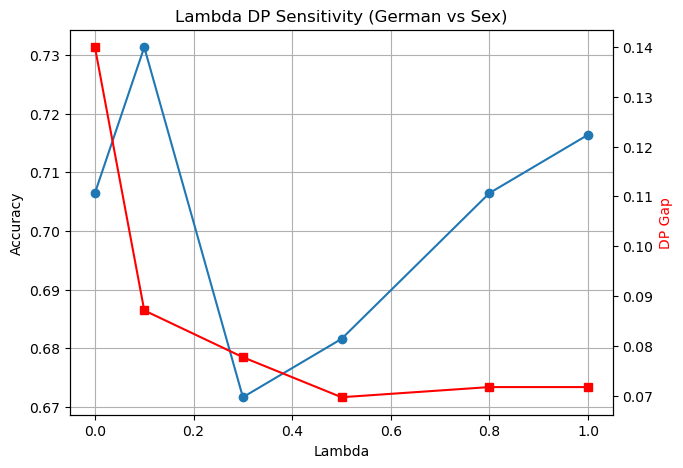

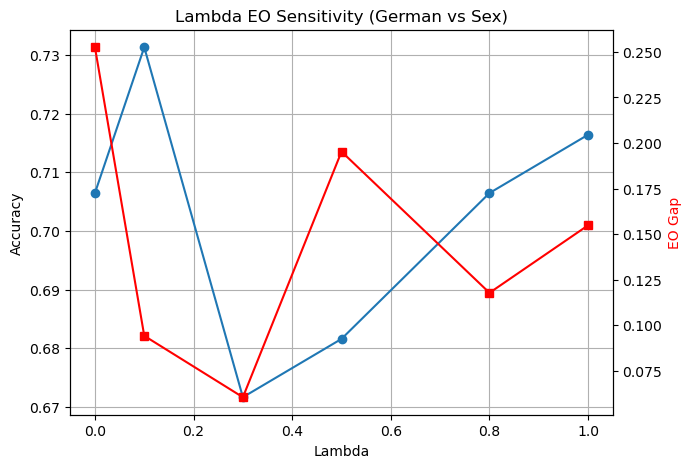

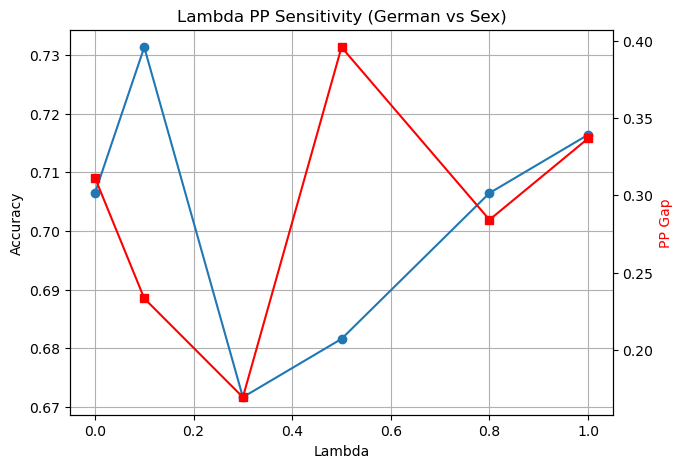

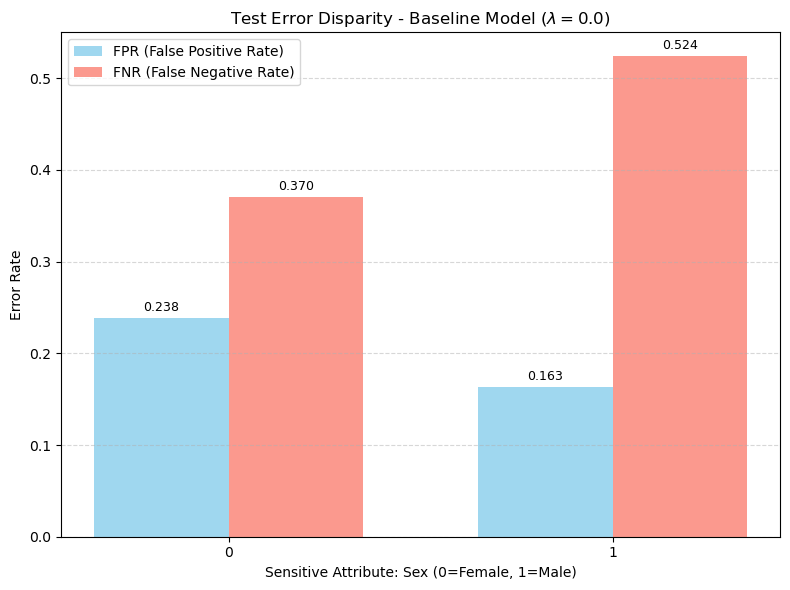

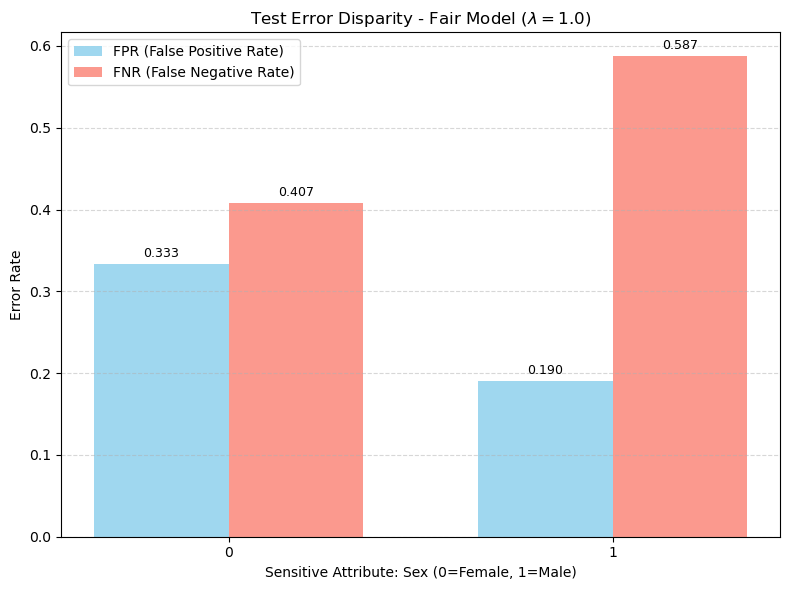

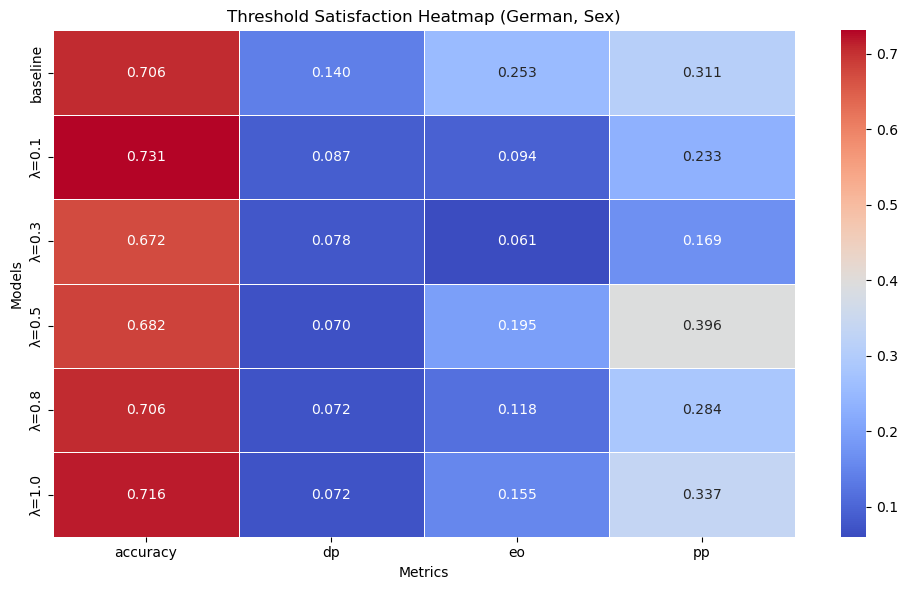

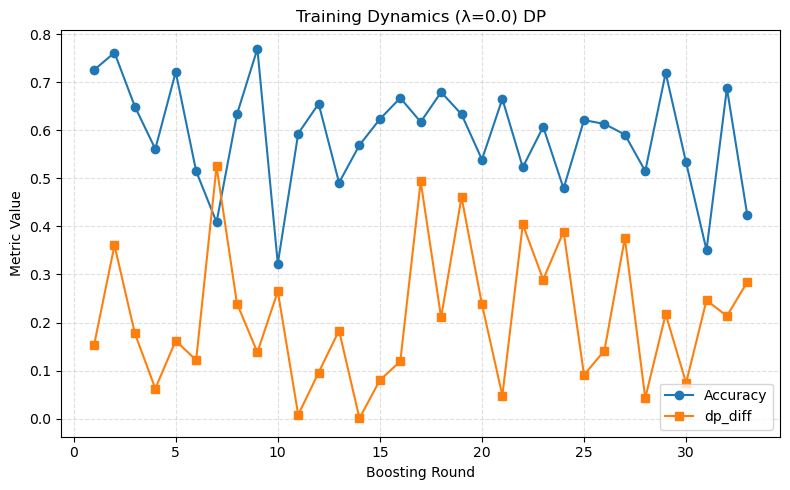

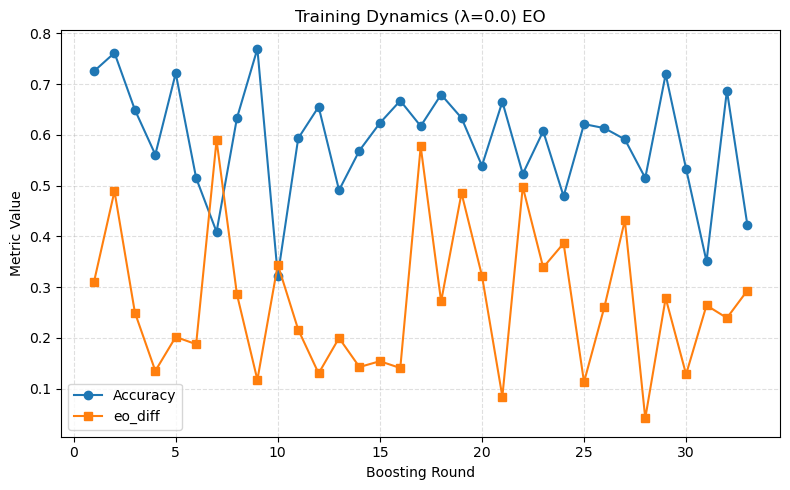

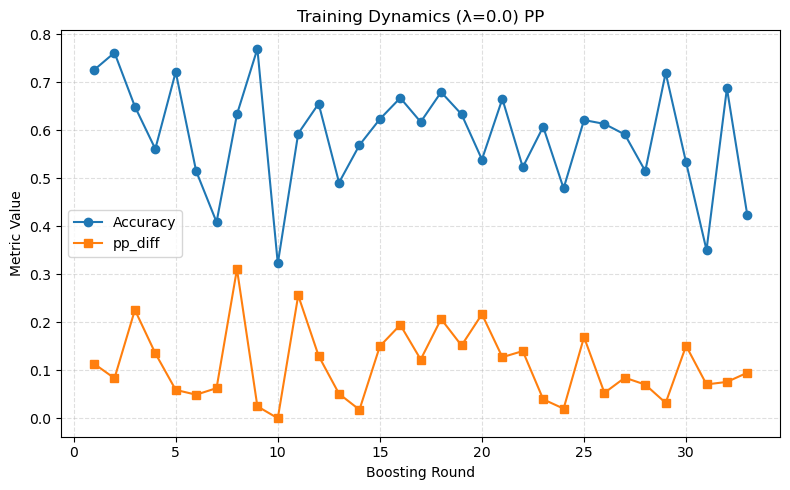

In [24]:
# German dataset fairness on sex
val_res_german_sex, test_german_sex, baseline_german_sex, best_german_sex = run_experiment(
    dataset_name="german",
    sensitive="sex",
    lambdas=(0.0, 0.1, 0.3, 0.5, 0.8, 1.0),
    n_estimators=40,
    fairness_tolerance=0.5,
)

plot_pareto_tradeoff(val_res_german_sex, title_suffix="(German, Sex)")
plot_lambda_sensitivity(val_res_german_sex, fairness_key="dp", title="Lambda DP Sensitivity (German vs Sex)")
plot_lambda_sensitivity(val_res_german_sex, fairness_key="eo", title="Lambda EO Sensitivity (German vs Sex)")
plot_lambda_sensitivity(val_res_german_sex, fairness_key="pp", title="Lambda PP Sensitivity (German vs Sex)")

Dataset: german, sensitive: age
Train shape: (499, 24) Val: (201, 24) Test: (300, 24)
lambda=0.00 | Acc=0.672, F1=0.353, MCC=0.146, DP=0.220, EO=0.400, PP=0.556, Train Time=1.13s, Val Time=0.0194s
lambda=0.10 | Acc=0.701, F1=0.423, MCC=0.233, DP=0.360, EO=0.444, PP=1.000, Train Time=1.01s, Val Time=0.0091s
lambda=0.30 | Acc=0.687, F1=0.376, MCC=0.182, DP=0.135, EO=0.600, PP=0.600, Train Time=0.91s, Val Time=0.0033s
lambda=0.50 | Acc=0.711, F1=0.500, MCC=0.298, DP=0.309, EO=0.600, PP=1.000, Train Time=5.70s, Val Time=0.0713s
lambda=0.80 | Acc=0.697, F1=0.450, MCC=0.244, DP=0.206, EO=0.500, PP=0.625, Train Time=5.08s, Val Time=0.0821s
lambda=1.00 | Acc=0.687, F1=0.471, MCC=0.248, DP=0.229, EO=0.600, PP=0.417, Train Time=2.12s, Val Time=0.0384s

Best lambda on validation (by F1): 0.0

=== Test metrics with best lambda ===
accuracy: 0.7133
precision: 0.5227
recall: 0.5111
f1: 0.5169
mcc: 0.3131
dp_diff: 0.2323
eo_diff: 0.5714
pp_diff: 0.7500
confusion_matrix =
 [[168  42]
 [ 44  46]]
train

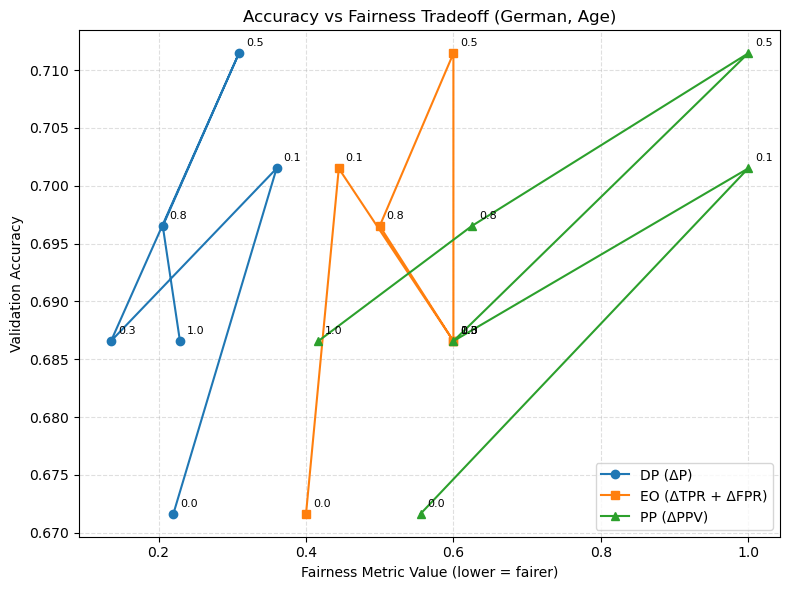

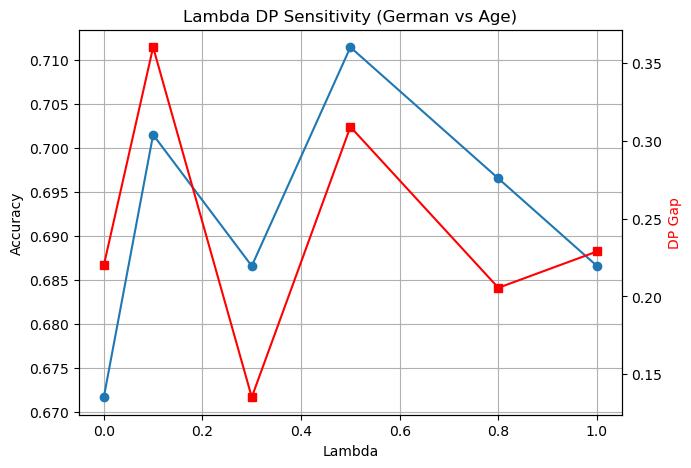

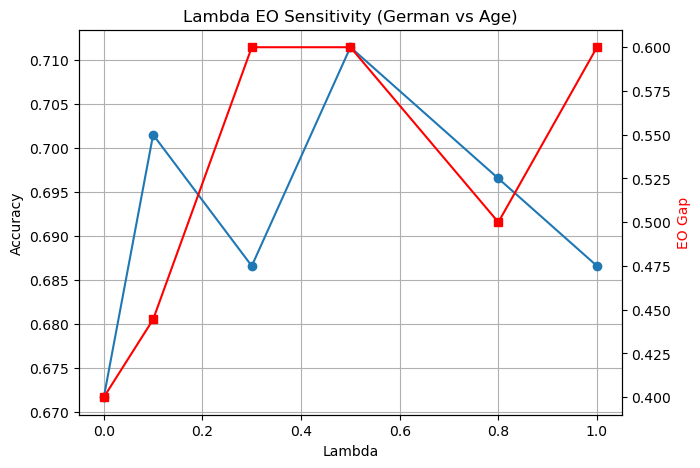

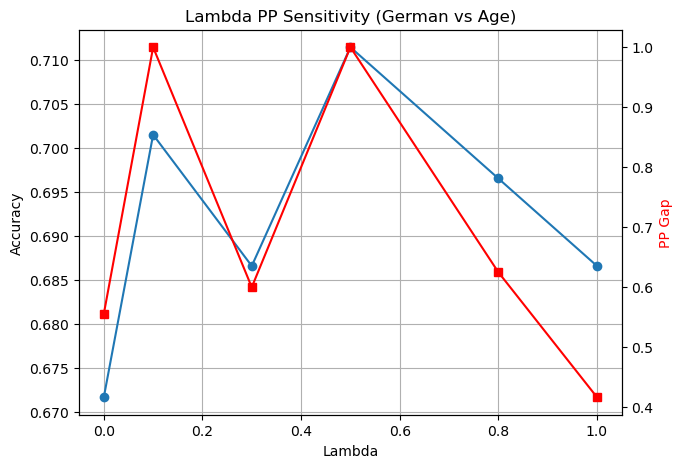

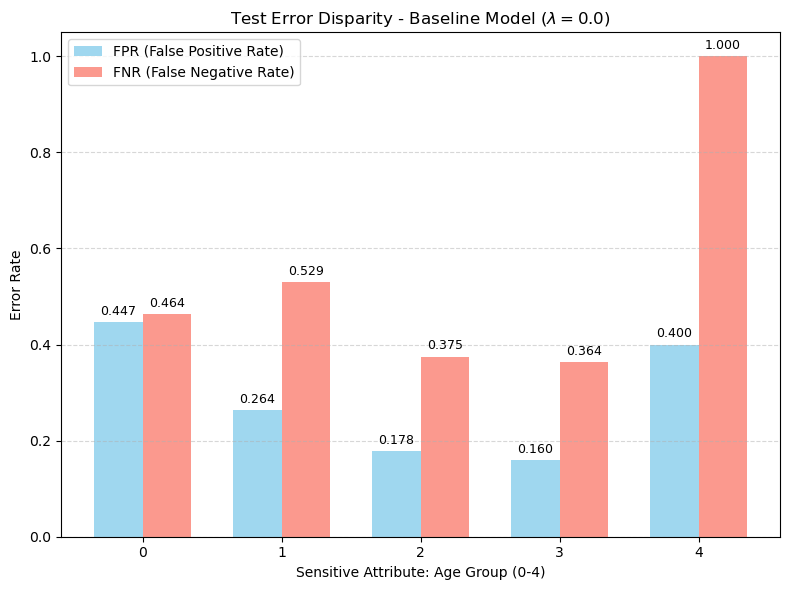

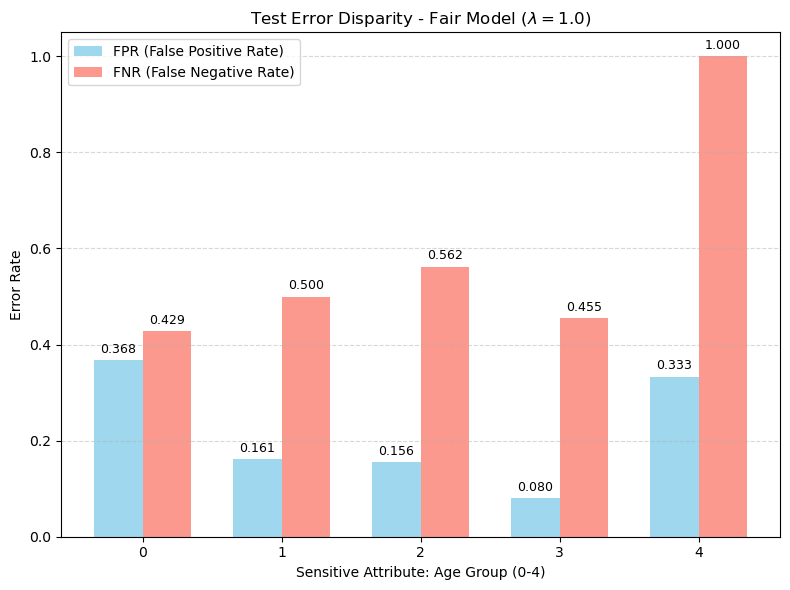

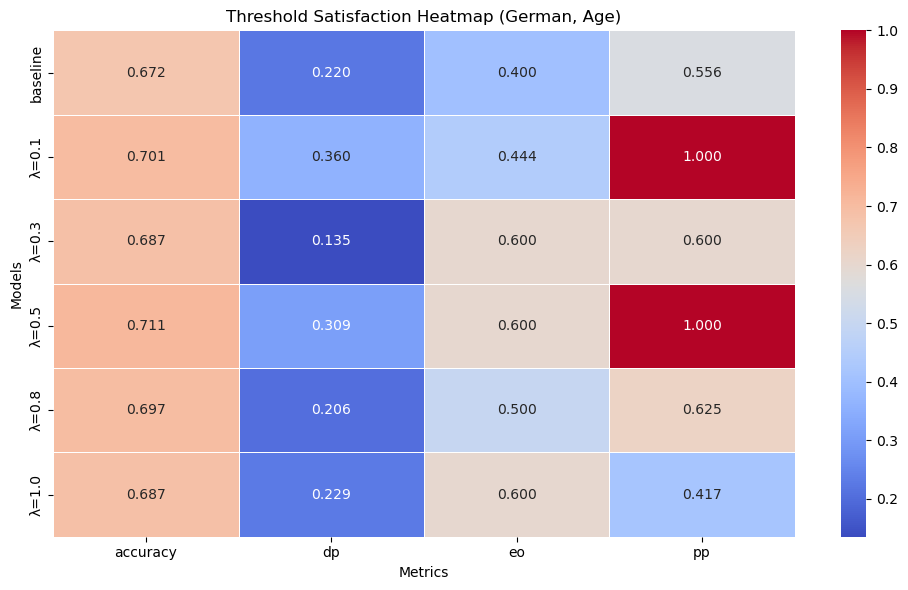

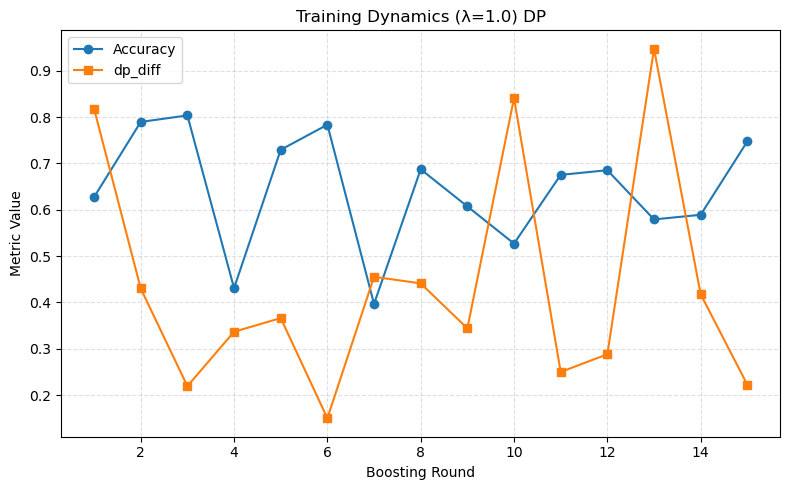

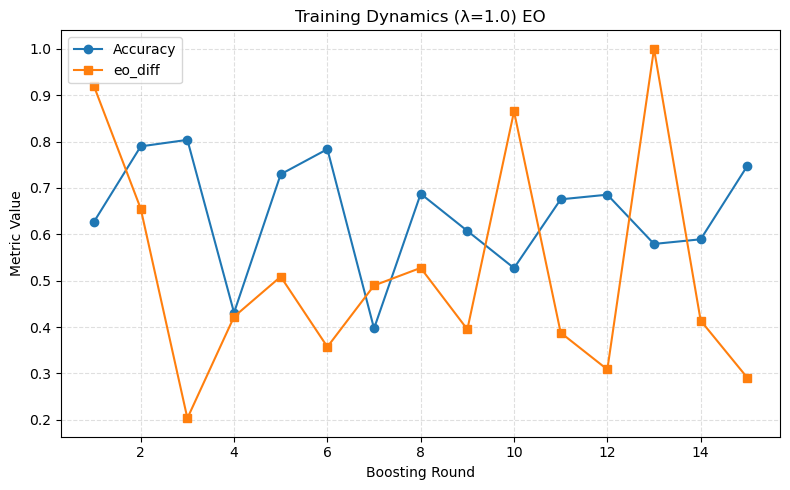

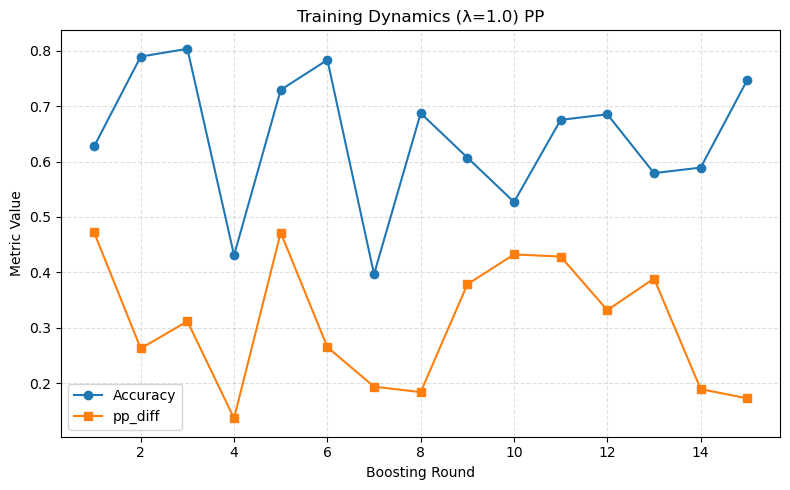

In [27]:
# German dataset fairness on age
val_res_german_age, test_german_age, baseline_german_age, best_german_age = run_experiment(
    dataset_name="german",
    sensitive="age",
    lambdas=(0.0, 0.1, 0.3, 0.5, 0.8, 1.0),
    n_estimators=40,
    fairness_tolerance=0.5,
)

plot_pareto_tradeoff(val_res_german_age, title_suffix="(German, Age)")
plot_lambda_sensitivity(val_res_german_age, fairness_key="dp", title="Lambda DP Sensitivity (German vs Age)")
plot_lambda_sensitivity(val_res_german_age, fairness_key="eo", title="Lambda EO Sensitivity (German vs Age)")
plot_lambda_sensitivity(val_res_german_age, fairness_key="pp", title="Lambda PP Sensitivity (German vs Age)")